# Spectral Axes, Velocity Frames and Conventions in `dysh`
----------------------------------

This notebook shows how to change spectral axes to represent different Doppler velocity frames and conventions.

In [1]:
import os
import wget
import astropy.units as u
from dysh.fits.gbtfitsload import GBTFITSLoad

## First, we download the example SDFITS data, if necessary.


In [2]:
filename = "TGBT21A_501_11.raw.vegas.fits"
if not os.path.isfile(filename):
    url = f"http://www.gb.nrao.edu/dysh/example_data/onoff-L/data/{filename}"
    print(f"Downloading {filename}")
    wget.download(url,out=filename)
    print(f"\nRetrieved {filename}")
else:
    print(f"{filename} already downloaded")

TGBT21A_501_11.raw.vegas.fits already downloaded


### Load the file

In [3]:
sdfits = GBTFITSLoad(filename)
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,152,NGC2415,3784.0,OnOff,1,1.617185,1.420406,5,2,151,1,286.218008,41.62843
1,153,NGC2415,3784.0,OnOff,2,1.617185,1.420406,5,2,151,1,286.886521,41.118134


## Next we fetch and calibrate the Position Switched data

In [4]:
psscan = sdfits.getps(scan=152, ifnum=0, plnum=0)

### Create the time-averaged spectrum, using $T_{sys}$ weighting

In [5]:
ta = psscan.timeaverage(weights='tsys')

-----------------------
### Example 1: Changing the x-axis of a spectrum plot
Note this changes the axis of the plot but does not affect the underlying Spectrum object.


#### The default plot uses the velocity frame and convvention found in the SDFIST File.
In this case, that is topocentric frame and the optical convention.

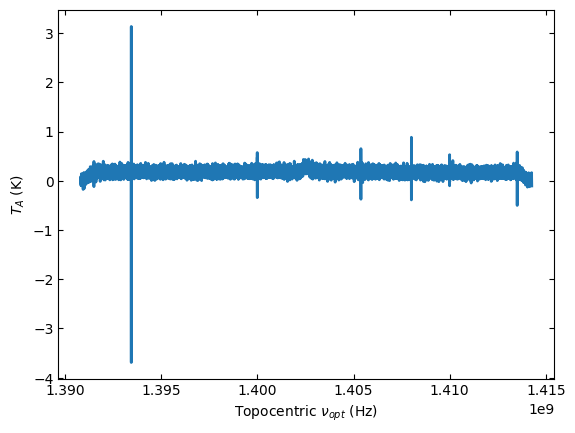

In [6]:
ta.plot()

### You can change the velocity frame by supplying one of the [built-in astropy coordinate frames](https://docs.astropy.org/en/stable/coordinates/index.html#built-in-frame-classes).  
These are specified by string name.   

### Plot barycentric frequency
The change here is small, a shift of 22.8 kHz. 

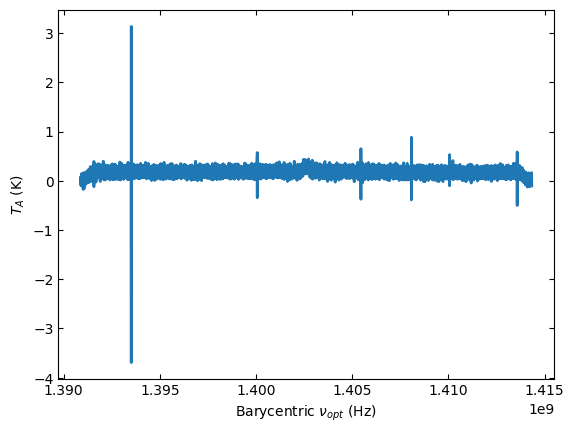

In [7]:
ta.plot(vel_frame='icrs')

### In addition to the astropy frame names, we also allow 'topo' and 'topocentric'.

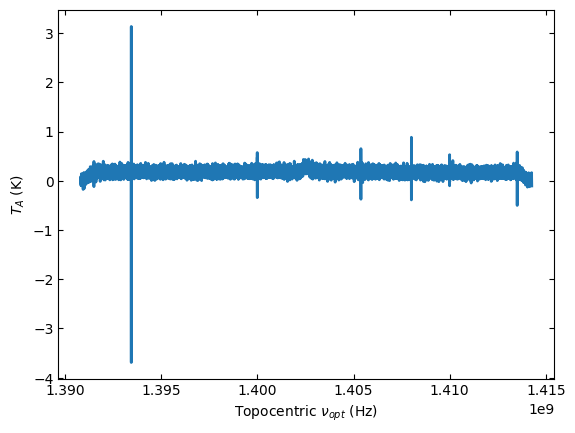

In [8]:
ta.plot(vel_frame='topo')

### One can also switch Doppler convention between `radio`, `optical`, and `relativistic`.
Here we also change the x-axis to velocity units and use LSRK frame.

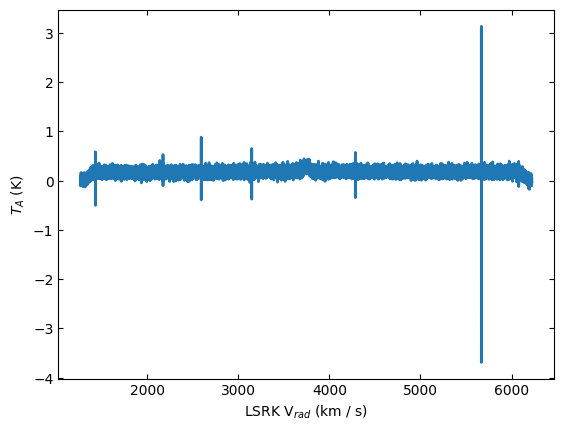

In [9]:
ta.plot(vel_frame='lsrk', doppler_convention='radio', xaxis_unit='km/s')

---------------


## Example 2. Changing the spectral axis of the Spectrum.
There are two ways to accomplish this.  One returns a copy of the original Spectrum with the new spectral axis; 
the other changes the spectral axis in place, the other 

### A.   Return a copy of the spectrum using [Spectrum.with_frame()](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.with_frame)

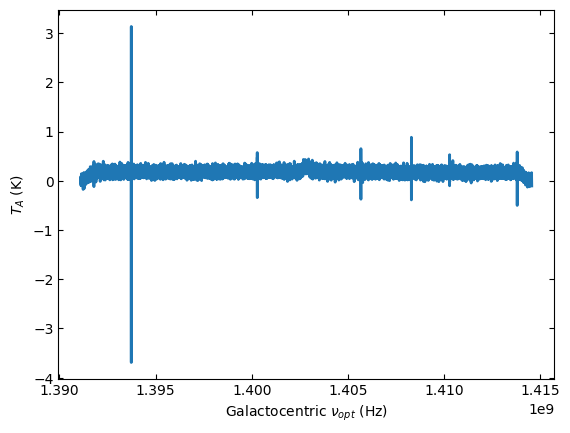

The new spectral axis frame is galactocentric


In [10]:
newspec = ta.with_frame('galactocentric')
newspec.plot()
print(f"The new spectral axis frame is {newspec.velocity_frame}")

#### One can see the spectral axis of the new spectrum is different.

In [11]:
ta.spectral_axis-newspec.spectral_axis

<Quantity [-188794.74925685, -188794.65377498, -188794.5582931 , ...,
           -185666.28610849, -185666.19062662, -185666.09514475] Hz>

### B.   Change the spectral axis in place using [Spectrum.set_frame()](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.set_frame)

In [12]:
sa = ta.spectral_axis
ta.set_frame('gcrs')
print(f"Changed spectral axis frame to  {ta.velocity_frame}")

Changed spectral axis frame to  gcrs


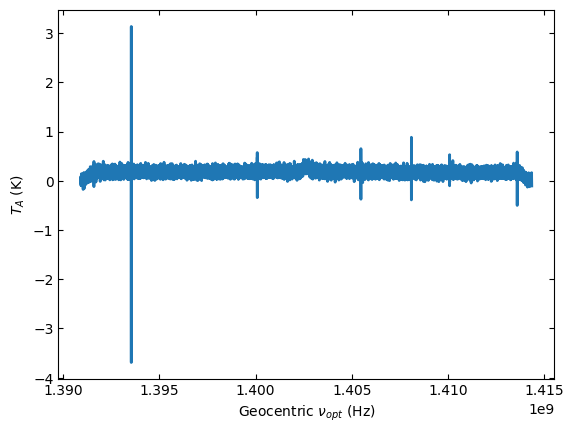

In [13]:
ta.plot()

#### Here the original the spectral axis has changed

In [14]:
ta.spectral_axis - sa

<Quantity [-10566.39799047, -10566.39264655, -10566.38730264, ...,
           -10391.30526757, -10391.29992366, -10391.29457974] Hz>

-----------

### Other useful functions

## Convert the spectral axis to any units, frame, and convention with [Spectrum.velocity_axis_to](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.velocity_axis_to)

In [15]:
ta.velocity_axis_to(unit="pc/Myr", toframe='heliocentric', doppler_convention='radio')

<SpectralAxis 
   (observer: <HCRS Coordinate (obstime=J2000.000): (x, y, z) in m
                  (-1.155065e+11, 8.55013476e+10, 3.70541336e+10)
               (v_x, v_y, v_z) in km / s
                  (0., 0., 0.)>
    target: <FK5 Coordinate (equinox=J2000.000): (ra, dec, distance) in (deg, deg, kpc)
                (114.23878994, 35.24315396, 1000000.)
             (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                (0., 9.36804086e-20, 3784.)>
    observer to target (computed from above):
      radial_velocity=3784.0148667382546 km / s
      redshift=0.012702788948768307
    doppler_rest=1420405751.7 Hz
    doppler_convention=radio)
  [1310.25989431, 1310.41429355, 1310.56869278, ..., 6369.15091567,
   6369.30531491, 6369.45971415] pc / Myr>

## Shift a spectrum in place to a given radial velocity or redshift with [Spectrum.shift_spectrum_to](https://specutils.readthedocs.io/en/stable/api/specutils.Spectrum1D.html#specutils.Spectrum1D.shift_spectrum_to)

In [16]:
print(f"before shift {ta.spectral_axis}")
ta.shift_spectrum_to(radial_velocity=0*u.km/u.s)
print(f"after shift {ta.spectral_axis}")

before shift [1.41433565e+09 1.41433494e+09 1.41433422e+09 ... 1.39089911e+09
 1.39089839e+09 1.39089768e+09] Hz
after shift [1.43230166e+09 1.43230094e+09 1.43230021e+09 ... 1.40856740e+09
 1.40856668e+09 1.40856596e+09] Hz


### Get the spectral axis in wavelength units
The default is angstrom, use [Quantity.to](https://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity.to) to convert to other units.

In [17]:
ta.wavelength.to('cm')

<SpectralAxis 
   (observer: <HCRS Coordinate (obstime=J2000.000): (ra, dec, distance) in (deg, deg, m)
                  (143.49005406, 14.45832442, 1.48409032e+11)
               (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                  (0., 0., 0.)>
    target: <FK5 Coordinate (equinox=J2000.000): (ra, dec, distance) in (deg, deg, kpc)
                (114.23878994, 35.24315396, 1000000.)
             (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                (1.90953509e-18, -1.14274584e-18, -0.01486674)>
    observer to target (computed from above):
      radial_velocity=-1.397892869167694e-12 km / s
      redshift=0.0
    doppler_rest=1420405751.7 Hz
    doppler_convention=optical)
  [20.9308183 , 20.93082888, 20.93083947, ..., 21.28350103, 21.28351198,
   21.28352292] cm>

### Also, you can plot the x-axis in channel units

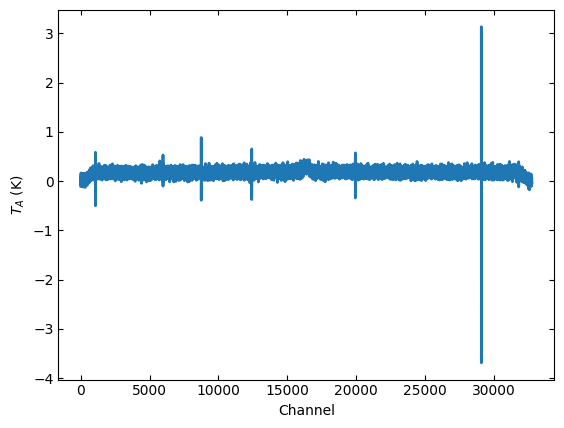

In [18]:
ta.plot(xaxis_unit='chan')